# Lab 04 Temporal Difference

In the last lab, we were trying to do **Makov Decision Process (MDP)** using **Monte Carlo method** which it a *model-free* approach. It does not require the prior knowledge environment. However, all algorithm that we learned, need to play until the end of episode, then it can update its knowledge. This is slow due to waiting some process to success or fail to terminate.

This lab, I introduce another method that can learn while it's running each sted. The method is called **Temporal Difference (TD)**. Because learning every time step in an episode, TD increased learning efficiency significantly.

## Algorithms in TD method

The TD method has 2 main algorithms family:
1. Q-Learning
2. SARSA

## Q-Learning

Q-Learning is a very popular TD method. It is an off-policy learning algorithm. The Q-function updates the Q policy based on the equation:

$$Q(s,a)=Q(s,a)+\alpha(r+\gamma \max_{a'}Q(s',a') - Q(s,a))$$

where
- s: currenct state
- s': next state after taking action
- a: action in the current state
- a': action will take when go to next state
- $\alpha$: learning rate
- $\gamma$: discount factor

$\max_{a'}Q(s',a')$ means the behavior policy is greedy, where the highest Q-value among those in state $s'$ is selected to generate learning data.

In Q-learning, actions are taken according to the epsilon-greedy policy.

## Q-Learning example: Cliff Walking

Now, let's do the Q-Learning algorithm using Cliff Walking environment.

In [2]:
import torch
import gym
from collections import defaultdict

In [3]:
env = gym.make("CliffWalking-v0")

### Define Epsilon greedy policy

As last time the epsilon greedy policy equation can be written as:

$$\pi(s,a) = \frac{\epsilon}{|A|}$$

when $|A|$ is the number of possible actions, and

$$\pi(s,a) = 1 - \epsilon + \frac{\epsilon}{|A|}$$

In [4]:
def gen_epsilon_greedy_policy(n_action, epsilon):
    def policy_function(state, Q):
        probs = torch.ones(n_action) * epsilon / n_action
        best_action = torch.argmax(Q[state]).item()
        probs[best_action] += 1.0 - epsilon
        action = torch.multinomial(probs, 1).item()
        return action
    return policy_function

### Define Q-learning function

We perform Q-learning in the tasks:

1. Initialize the Q-table with all zeros.
2. In each episode, we let the agent follow the epsilon-greedy policy to choose what action to take. And we update the Q function for each step.
3. Run <code>n_episodes</code> episodes
4. Obtain the optimal policy based on the optimal Q function.

In [5]:
def q_learning(env, gamma, n_episode, alpha):
    """
    Obtain the optimal policy with off-policy Q-learning method
    @param env: OpenAI Gym environment
    @param gamma: discount factor
    @param n_episode: number of episodes
    @return: the optimal Q-function, and the optimal policy
    """
    n_action = env.action_space.n
    Q = defaultdict(lambda: torch.zeros(n_action))
    for episode in range(n_episode):
        state = env.reset()
        is_done = False
        while not is_done:
            action = epsilon_greedy_policy(state, Q)
            next_state, reward, is_done, info = env.step(action)
            # update Q here
            td_delta = reward + gamma * torch.max(Q[next_state]) - Q[state][action]
            Q[state][action] += alpha * td_delta

            length_episode[episode] += 1
            total_reward_episode[episode] += reward

            if is_done:
                break
            state = next_state

    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy

### Define initial parameters

We specify the $\gamma=1$, $\alpha=0.4$, and $\epsilon=0.1$ with 500 episodes

In [6]:
gamma = 1
alpha = 0.4
epsilon = 0.1

n_episode = 500

### Create an instance of the epsilon-greedy policy function

In [8]:
epsilon_greedy_policy = gen_epsilon_greedy_policy(env.action_space.n, epsilon)

print(epsilon_greedy_policy)

<function gen_epsilon_greedy_policy.<locals>.policy_function at 0x7f9a080238b0>


### Learn it

we perform Q-learning with input parameters defined previously and print out the optimal policy

In [10]:
length_episode = [0] * n_episode
total_reward_episode = [0] * n_episode

optimal_Q, optimal_policy = q_learning(env, gamma, n_episode, alpha)

print('The optimal policy:\n', optimal_policy)

The optimal policy:
 {36: 0, 24: 1, 12: 0, 0: 3, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 0, 7: 2, 8: 1, 20: 1, 9: 1, 10: 2, 11: 2, 23: 2, 22: 1, 21: 1, 19: 1, 18: 1, 17: 1, 16: 1, 15: 1, 14: 1, 13: 1, 34: 1, 35: 2, 33: 1, 32: 1, 31: 1, 30: 1, 29: 1, 28: 1, 27: 1, 26: 1, 25: 1, 47: 0}


### Display the plot of episode

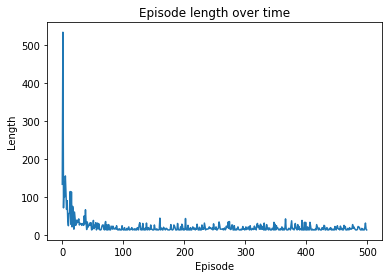

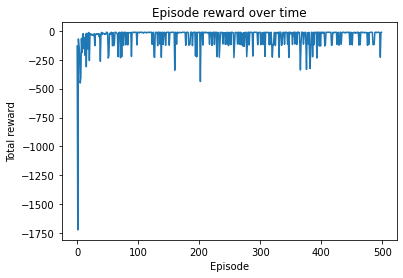

In [20]:
import matplotlib.pyplot as plt
plt.plot(length_episode)
plt.title('Episode length over time')
plt.xlabel('Episode')
plt.ylabel('Length')
plt.show()


plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

### Simulate the optimal policy

In [18]:
import time
from IPython.display import clear_output

def simulate_episode_render(env, policy):
    state = env.reset()
    is_done = False
    while not is_done:
        try:
            action = policy[state]
            print("get action")
        except:
            action = 0
            print("no action")
        print(action)
        state, reward, is_done, info = env.step(action)
        env.render()
        time.sleep(0.9)
        
        clear_output(wait=True)
        if is_done:
            return reward

In [19]:
simulate_episode_render(env, optimal_policy)

-1

### BipedalWalker with Q-Learning

Let's do more advance environment, BipedalWalker.

Now, see the simulator (random action)

In [3]:
import numpy as np
import random
import gym
import math
import torch
from collections import defaultdict, deque
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

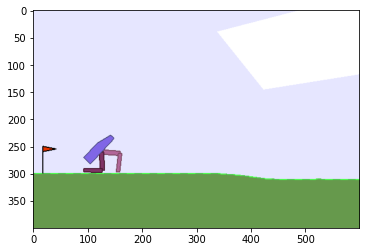

In [2]:
env = gym.make("BipedalWalker-v3")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    screen = env.render(mode='rgb_array')

    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

    if done:
        break

ipythondisplay.clear_output(wait=True)
env.close()

### States and actions explanation

The scope of BipedalWalker is to "Get a 2D biped walker to walk through rough terrain".

BipedalWalker-v3 is a challenging environment in the Gym. Your agent should run very fast, should not trip himself off, should use as little energy as possible.

You can find environment strategies in [openAI wiki page](https://github.com/openai/gym/wiki/BipedalWalker-v2)


### State observation

Each joint in Bipedal is in the figure:

<img src="img/1.png" title="Markov chain" style="width: 600px;" />

Here is the observation table from the same link, with 24 different parameters in one state:

<img src="img/2.png" title="Markov chain" style="width: 500px;" />

See the state

In [4]:
state = env.reset()

print(state)

[ 2.7468416e-03  4.6004689e-06 -5.9984683e-04 -1.6000031e-02
  9.2298970e-02  1.3924970e-03  8.5999709e-01  2.9593435e-04
  1.0000000e+00  3.2665040e-02  1.3924618e-03  8.5363185e-01
 -9.4750460e-04  1.0000000e+00  4.4081357e-01  4.4581968e-01
  4.6142232e-01  4.8954970e-01  5.3410226e-01  6.0246044e-01
  7.0914817e-01  8.8593090e-01  1.0000000e+00  1.0000000e+00]


### Action Space

BipedalWalker has two legs. Each leg has two joints. You have to teach the Bipedal-walker to walk by applying the torque on these joints. Therefore the size of our action space is four which is the torque applied on four joints. You can use the torque in the range of (-1, 1), as shown in the following table:

<img src="img/3.png" title="Markov chain" style="width: 500px;" />

We set state bounds and action bounds

In [5]:
stateBounds = [(0, math.pi),
           (-2,2),
           (-1,1),
           (-1,1),
           (0,math.pi),
           (-2,2),
           (0, math.pi),
           (-2,2),
           (0,1),
           (0, math.pi),
           (-2, 2),
           (0, math.pi),
           (-2, 2),
           (0, 1)]

actionBounds = (-1, 1)

### Reward

The agent gets a positive reward proportional to the distance walked on the terrain. It can get a total of 300+ reward points up to the end;
If the agent tumbles, it gets a negative reward of -100;
There is some negative reward proportional to the torque applied on the joint. So that agent learns to walk smoothly with minimal torque.

### Initialize parameters

In [6]:
n_episode = 1000
gamma =  0.99
alpha = 0.01
highscore = -200

### convert states to be discrete

Because the positions of Bipedal are continuous, we need to convert the state to be discreate

In [7]:
def discretizeState(state):
    discreteState = []

    for i in range(len(state)):

        index = int((state[i]-stateBounds[i][0])  / (stateBounds[i][1]-stateBounds[i][0])*19)
        discreteState.append(index)
    
    return tuple(discreteState)

### convert actions to be dicrete

And also the actions which is continuous, we need to convert the action angle to be discrete too.

In [8]:
def convertNextAction(nextAction):
    # convert action number to be the continuous value
    action = []

    for i in range(len(nextAction)):
        nextVal = nextAction[i] / 9 * 2 - 1
        action.append(nextVal)

    return tuple(action)

def getNextAction(qTable, epsilon, state):
    # random a number which tel that we should random or select from Q-table
    if random.random() < epsilon:
        action = ()
        for i in range (0, 4):
            action += (random.randint(0, 9),)
    else:
        action = np.unravel_index(np.argmax(qTable[state]), qTable[state].shape)

    return action

### Create Q-learning function

In [9]:
def plotEpisode(myGraph, xval, yval, epScore, plotLine, i):

    xval.append(i)
    yval.append(epScore)

    plotLine.set_xdata(xval)
    plotLine.set_ydata(yval)
    myGraph.savefig("./plot")

In [10]:
def q_learning(env, gamma, n_episode, alpha):
    """
    Obtain the optimal policy with off-policy Q-learning method
    @param env: OpenAI Gym environment
    @param gamma: discount factor
    @param n_episode: number of episodes
    @return: the optimal Q-function, and the optimal policy
    """
    Q = defaultdict(lambda: torch.zeros((10, 10, 10, 10)))
    
    # Initialize graph
    myGraph = plt.figure()
    xval, yval = [], []
    mySubPlot = myGraph.add_subplot()
    plt.xlabel("Episode #")
    plt.ylabel("Score")
    plt.title("Scores vs Episode")
    plotLine, = mySubPlot.plot(xval, yval)
    mySubPlot.set_xlim([0, n_episode])
    mySubPlot.set_ylim([-220, -80])
    ##########################
    
    highscore = -200
    
    for episode in range(n_episode):
        print("Start Episode", episode+1)
        epsilon = 1.0 / ( (episode+1) * .004)
        
        state = env.reset()
        state = discretizeState(state[0:14])
        
        is_done = False
        while not is_done:
            actionDiscretized = getNextAction(Q, epsilon, state)
            action = convertNextAction(actionDiscretized)
            
            next_state, reward, is_done, info = env.step(action)
            next_state = discretizeState(next_state[0:14])
            # update Q here
            td_delta = reward + gamma * torch.max(Q[next_state]) - Q[state][actionDiscretized]
            Q[state][actionDiscretized] += alpha * td_delta

            length_episode[episode] += 1
            total_reward_episode[episode] += reward

            if is_done:
                print("Episode finished. Now plotting..")
                plotEpisode(myGraph, xval, yval, total_reward_episode[episode], plotLine, episode+1)
                ipythondisplay.clear_output(wait=True)
                break
            state = next_state
            
        if total_reward_episode[episode] > highscore:
            highscore = total_reward_episode[episode]

    return Q, highscore

### Training

All episodes finished. Highest score achieved: -81.67823062380586


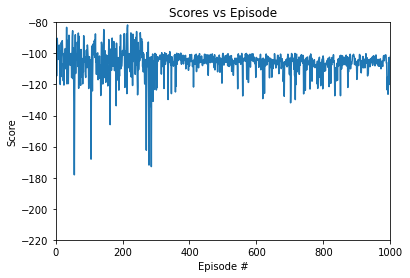

In [11]:
length_episode = [0] * n_episode
total_reward_episode = [0] * n_episode

optimal_Q, highscore = q_learning(env, gamma, n_episode, alpha)

print("All episodes finished. Highest score achieved: " + str(highscore))

### Simulate the best policy

In [12]:
import time
from IPython.display import clear_output

def simulate_episode_render(env, Q):
    state = env.reset()
    state = discretizeState(state[0:14])
    is_done = False
    while not is_done:
        actionDiscretized = getNextAction(Q, 0, state)
        action = convertNextAction(actionDiscretized)
        print(action)
        state, reward, is_done, info = env.step(action)
        state = discretizeState(state[0:14])
        screen = env.render(mode='rgb_array')

        plt.imshow(screen)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())
        if is_done:
            return reward

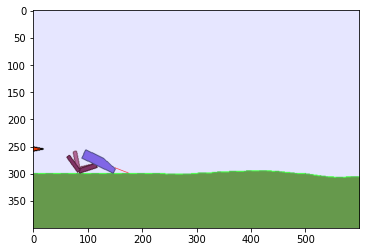

-100

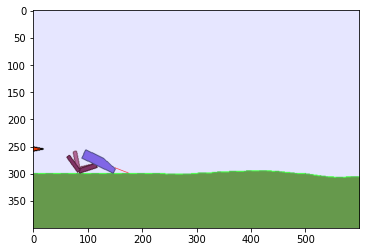

In [13]:
simulate_episode_render(env, optimal_Q)

## SARSA

As the Q-learning is an off-policy TD learning algorithm. In the opposite, there is an on-policy TD learning algorithm, called **State-Action-Reward-State-Action (SARSA)**.

Similar to Q-learning, SARSA focuses on state-action values. It updates the Q-function based on the following equation:

$$Q(s,a)=Q(s,a)+\alpha(r+\gamma Q(s',a') - Q(s,a))$$

You will recall that in Q-learning, a behavior-greedy policy, $\max_{a'}Q(s',a')$, is used to update the Q value. In SARSA, we simply pick up the next action, $a'$, by also following an epsilon-greedy policy to update the Q value. And the action a' is taken in the next step. Hence, SARSA is an on-policy algorithm.

We perform SARSA to solve the Taxi environment as follows:

In [15]:
import torch
import gym

env = gym.make('Taxi-v3')

In [16]:
def gen_epsilon_greedy_policy(n_action, epsilon):
    def policy_function(state, Q):
        probs = torch.ones(n_action) * epsilon / n_action
        best_action = torch.argmax(Q[state]).item()
        probs[best_action] += 1.0 - epsilon
        action = torch.multinomial(probs, 1).item()
        return action
    return policy_function

### Create SARSA function

In [17]:
from collections import defaultdict

def sarsa(env, gamma, n_episode, alpha):
    """
    Obtain the optimal policy with on-policy SARSA algorithm
    @param env: OpenAI Gym environment
    @param gamma: discount factor
    @param n_episode: number of episodes
    @return: the optimal Q-function, and the optimal policy
    """
    n_action = env.action_space.n
    Q = defaultdict(lambda: torch.zeros(n_action))
    for episode in range(n_episode):
        state = env.reset()
        is_done = False
        action = epsilon_greedy_policy(state, Q)
        while not is_done:
            next_state, reward, is_done, info = env.step(action)
            next_action = epsilon_greedy_policy(next_state, Q)
            td_delta = reward + gamma * Q[next_state][next_action] - Q[state][action]
            Q[state][action] += alpha * td_delta
            length_episode[episode] += 1
            total_reward_episode[episode] += reward
            if is_done:
                break
            state = next_state
            action = next_action
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy

### Training

In [18]:
gamma = 1
n_episode = 1000

alpha = 0.4
epsilon = 0.01
epsilon_greedy_policy = gen_epsilon_greedy_policy(env.action_space.n, epsilon)

In [19]:
length_episode = [0] * n_episode
total_reward_episode = [0] * n_episode

optimal_Q, optimal_policy = sarsa(env, gamma, n_episode, alpha)

### Plotting the graph

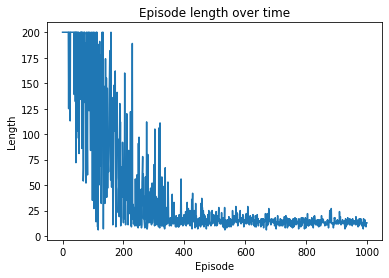

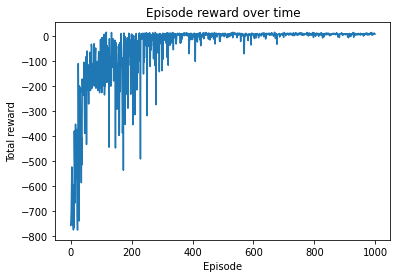

In [20]:
import matplotlib.pyplot as plt
plt.plot(length_episode)
plt.title('Episode length over time')
plt.xlabel('Episode')
plt.ylabel('Length')
plt.show()


plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

As you can see in the SARSA method, it optimizes the Q function by taking the action chosen under the same policy, the epsilon-greedy policy. This is quite similar to the on-policy MC control method. The difference is that it updates the Q function by small derivatives in individual steps, rather than after the entire episode. It is considered advantageous for environments with long episodes where it is inefficient to delay learning until the end of an episode. In every single step in SARSA, we gain more information about the environment and use this information to update values right away. In our case, we obtained the optimal policy by running only 500 learning episodes.

### Lab Exercise

1. Try to implement Taxi environment in Q-Learning and explain the difference between Q-Learning and SARSA
2. Try to implement BipedalWalking in Q-Learning and SARSA in higer episodes such as 10,000 episodes or more. Record the vdos and submit.
3. Play Car racing using Q-Learning **OR** SARSA